## Identify the potential factors affecting the reproducibility of proteins

**Input:** 
<ul>
    <li> Aggregated protein reproducibility rank</li>
    <li> CCLE, Colon and OV reproducibility correlation</li>
    <li> Protein properties - abundance, unique peptides, half-lives.</ul>
</ul>          

#### Import Packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import common_utils
import graphing_utils as gu
import customized_plots
%matplotlib inline
plt.style.use(['seaborn-white'])

In [2]:
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+'/'+'/'.join(folders) +'/'+ fname)

file_proteomic_replicate_ranks = get_local_data_path(['results'], 'TableS2.xlsx')
file_protein_properties = get_local_data_path(['processed'], 'protein_properties.csv')

#### Load data

In [3]:
proteomic_replicate_rank = pd.read_excel(file_proteomic_replicate_ranks, sheet_name='B. Protein reproducibility rank', 
                                         index_col=0)
proteomic_replicate_rank.rename(columns = lambda x: x.replace(' Reproducibility Rank', ''), inplace=True)
proteomic_replicate_rank[:2]

,Ovarian,Colon,CCLE,Aggregated
A1BG,0.772775,0.45424,NaN,0.575671
A2M,0.883270,0.39603,0.22406,0.501120


In [4]:
aggregated_ranks = proteomic_replicate_rank['Aggregated'].copy(deep=True).dropna()
replicates_ccle_ranks = proteomic_replicate_rank['CCLE'].copy(deep=True).dropna()
replicates_ov_ranks = proteomic_replicate_rank['Ovarian'].copy(deep=True).dropna()
replicates_colon_ranks = proteomic_replicate_rank['Colon'].copy(deep=True).dropna()

In [5]:
protein_properties = pd.read_csv(file_protein_properties, index_col=0)
protein_properties[:2]

,GTEx_Mean_Abundance,GTEx_Unique_Peptides,Protein sequence length,Molecular weight [kDa],T1/2 [h]
A1BG,1357.680477,22.0,NaN,NaN,NaN
A2M,10540.179562,77.0,NaN,NaN,NaN


In [6]:
protein_abundance = protein_properties['GTEx_Mean_Abundance'].copy(deep=True).dropna()
protein_unique_peptides = protein_properties['GTEx_Unique_Peptides'].copy(deep=True).dropna()
protein_half_lives = protein_properties['T1/2 [h]'].copy(deep=True).dropna()

In [7]:
print("Protien half-life Range: ", protein_half_lives.min(), " - ", protein_half_lives.max())
print("Protien mean abundance Range: ", protein_abundance.min(), " - ", protein_abundance.max())
print("Protien unique peptides Range: ", protein_unique_peptides.min(), " - ", protein_unique_peptides.max())
print("Thus, log-transformation is applied to all the above factors!")
protein_abundance = np.log10(protein_abundance + 1)
protein_unique_peptides = np.log10(protein_unique_peptides + 1)
protein_half_lives = np.log10(protein_half_lives + 1)

Protien half-life Range:  0.2331348885205769  -  inf
Protien mean abundance Range:  76.17350896130952  -  387741.52997729526
Protien unique peptides Range:  1.0  -  2558.0
Thus, log-transformation is applied to all the above factors!


In [8]:
#converting half-lives to binary - 'Long' and 'Short' 
protein_half_lives_binary = pd.Series(['Long' if val > protein_half_lives.median() \
                                       else 'Short' for val in protein_half_lives], index=protein_half_lives.index)

**Performing Mann-Whitney test to ensure the Aggregated Protein Reproduciility Rank are protein half-lives 'Long' and 'short' are from different distribution**

In [9]:
protein_half_lives_ranks = pd.concat([protein_half_lives_binary, aggregated_ranks, replicates_ccle_ranks, 
                                      replicates_colon_ranks, replicates_ov_ranks], axis=1)
protein_half_lives_ranks.columns= ['half-life', 'AggregatedRank', 'CCLE', 'Colon', 'OV']
protein_half_lives_ranks[:2]

,half-life,AggregatedRank,CCLE,Colon,OV
AACS,Long,0.629721,0.837034,NaN,0.552130
AAK1,Long,0.412224,0.532869,0.366083,0.337721


In [10]:
import scipy.stats as stats
print('Mann-Whitney U statistic p-value for Long vs. Short Protein half-lives: p-val = ', 
     stats.mannwhitneyu(protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Long']['AggregatedRank'].dropna(), 
                       protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Short']['AggregatedRank'].dropna(), 
                       alternative='two-sided')[1])

Mann-Whitney U statistic p-value for Long vs. Short Protein half-lives: p-val =  1.439746334973342e-24


#### Regress to understand the amount of variation in aggregated ranks explained by each of the factor

In [11]:
import statsmodels.api as sm
def ols_fit(x, y, match_subsets=True):
    x_subset, y_subset = common_utils.get_matched_index(x, y) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset)).fit()
    return est

In [12]:
combined_factors = pd.concat([protein_abundance, pd.get_dummies(protein_half_lives_binary), 
                                    protein_unique_peptides], axis=1, join='inner')
print('Dimensions: ', combined_factors.shape)
combined_factors[:2]

Dimensions:  (3713, 4)


,GTEx_Mean_Abundance,Long,Short,GTEx_Unique_Peptides
AACS,2.494105,1,0,1.230449
AAK1,2.954609,1,0,1.431364


In [13]:
rsquared_abundance = {} ; rsquared_peptides = {} ; rsquared_halflives = {} ; rsquared_all_factors = {} ;

rsquared_abundance[aggregated_ranks.name] = round(ols_fit(x=protein_abundance, y=aggregated_ranks).rsquared_adj*100, 2)
rsquared_peptides[aggregated_ranks.name] = round(ols_fit(x=protein_unique_peptides, y=aggregated_ranks).rsquared_adj*100, 
                                                 2)
# Since categorical variables are not directly used in OLS, generate dummies variables for regression
rsquared_halflives[aggregated_ranks.name] = round(ols_fit(x=pd.get_dummies(protein_half_lives_binary), 
                                                          y=aggregated_ranks).rsquared_adj*100, 2)
rsquared_all_factors[aggregated_ranks.name] = round(ols_fit(y=aggregated_ranks, 
                                                            x=combined_factors).rsquared_adj * 100, 2)

C:\Users\swath\Anaconda3\envs\omics_reproducibility\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [14]:
ylab = 'Aggregated Protein \nReproducibility Ranks'
palette = [gu.get_color('green')]
args = [gu.additional_plot_parameters(ylab=ylab,palette=palette, r2=rsquared_abundance[aggregated_ranks.name],
                                      xlab="GTEX 32 healthy tissues mean abundance (log transformed) deciles"),
        gu.additional_plot_parameters(ylab=ylab, palette=palette, r2=rsquared_peptides[aggregated_ranks.name],
                                      xlab="GTEx unique peptides count (log transformed) deciles"),        
        gu.additional_plot_parameters(ylab=ylab, palette=palette, xlab="Protein half-lives", 
                                      r2=rsquared_halflives[aggregated_ranks.name])]

In [15]:
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
def draw_violinplot(ax, x, y, args):
    x_subset, y_subset = common_utils.get_matched_index(x, y)
    dataframe = pd.DataFrame('', index=x_subset.index, columns=[y.name, 'Protein half-life'])
    dataframe[y.name] = y_subset
    dataframe['Protein half-life'] = x_subset

    sns.violinplot(y=y.name, ax=ax, x='Protein half-life', data=dataframe, 
                   order=["Short", "Long"], color="#009E73", inner='box')
    medians = dataframe.groupby(['Protein half-life'])[y.name].median().round(2).sort_values()
    count = len(dataframe)
    
    for xtick in ax.get_xticks():        
        ax.text(xtick+0.1, medians.iloc[xtick] + 0.025, medians.iloc[xtick], 
                horizontalalignment='center',size='9',color='black')
    ax.text(ax.get_xticks()[-1]+0.85, (ax.get_yticks()[-1] - 0.1) , 
            'N = '+ str(count), horizontalalignment='center',size='10',
            color='black')
    ax.set_xlim(right=2)
    if(args.r2!=None):
        at = AnchoredText("$\mathregular{R^2}$ = "+ str(round(args.r2, 2))+"%", loc="lower right", frameon=True,
                               prop=dict(fontsize='10', color='black'))
        at.patch.set_edgecolor('white')
        at.patch.set_facecolor('white')
        at.patch.set_alpha(0.6)  
        ax.add_artist(at)
    
    customized_plots.customise_plot(ax, args)

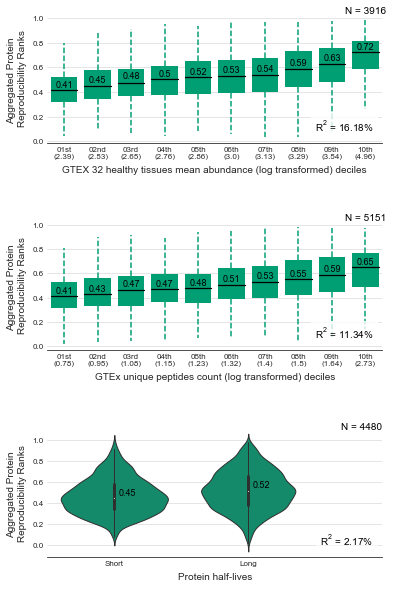

In [16]:
with plt.rc_context({'axes.linewidth': 0.8}):
    figure, ax = plt.subplots(3, 1, figsize=(6,10))
    customized_plots.draw_boxplot(ax[1], protein_unique_peptides, aggregated_ranks, args[1])
    customized_plots.draw_boxplot(ax[0], protein_abundance, aggregated_ranks, args[0])
    draw_violinplot(ax[2], protein_half_lives_binary, aggregated_ranks, args[2])
    plt.subplots_adjust(hspace=0.6)
    figure.savefig('../figures/Figure5.svg', bbox_inches='tight', dpi=300)

#### Validate the findings using the potential feature agaianst individual study's protein reproducibility rank

In [17]:
print('Ovarian Cancer: \nMann-Whitney U statistic for Long vs. Short Protein half-lives: p-val = ', 
      stats.mannwhitneyu(protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Long']['OV'].dropna(), 
                         protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Short']['OV'].dropna(), 
                         alternative='two-sided')[1])

print('Colon Cancer: \nMann-Whitney U statistic for Long vs. Short Protein half-lives: p-val = ', 
      stats.mannwhitneyu(protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Long']['Colon'].dropna(), 
                         protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Short']['Colon'].dropna(), 
                         alternative='two-sided')[1])

print('CCLE Cancer: \nMann-Whitney U statistic for Long vs. Short Protein half-lives: p-val = ', 
      stats.mannwhitneyu(protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Long']['CCLE'].dropna(), 
                         protein_half_lives_ranks[protein_half_lives_ranks['half-life']=='Short']['CCLE'].dropna(), 
                         alternative='two-sided')[1])

Ovarian Cancer: 
Mann-Whitney U statistic for Long vs. Short Protein half-lives: p-val =  1.2708871714937864e-41
Colon Cancer: 
Mann-Whitney U statistic for Long vs. Short Protein half-lives: p-val =  0.04724911115331449
CCLE Cancer: 
Mann-Whitney U statistic for Long vs. Short Protein half-lives: p-val =  4.9321539234919467e-17


In [18]:
all_replicate_ranks = [replicates_colon_ranks, replicates_ov_ranks, replicates_ccle_ranks, aggregated_ranks]

for study in all_replicate_ranks:
    rsquared_abundance[study.name] = round(ols_fit(x=protein_abundance, y=study).rsquared_adj*100, 2)
    rsquared_peptides[study.name] = round(ols_fit(x=protein_unique_peptides, y=study).rsquared_adj*100, 2)
    rsquared_halflives[study.name] = round(ols_fit(x=pd.get_dummies(protein_half_lives_binary), 
                                                   y=study).rsquared_adj*100, 2)

C:\Users\swath\Anaconda3\envs\omics_reproducibility\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [19]:
ylab = "Protein Reproducibility Ranks"
xlab1 = 'GTEX 32 healthy tissues mean abundance\n(log transformed) deciles'
xlab2 = 'GTEx unique peptides count (log transformed) deciles'
xlab3 = 'Protein half-lives'

args = [gu.additional_plot_parameters(ylab=ylab, xlab=xlab1, palette=palette, r2=rsquared_abundance[replicates_colon_ranks.name]),
        gu.additional_plot_parameters(ylab=ylab, xlab=xlab1, palette=palette, r2=rsquared_abundance[replicates_ov_ranks.name]),
        gu.additional_plot_parameters(ylab=ylab, xlab=xlab1, palette=palette, r2=rsquared_abundance[replicates_ccle_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab2, palette=palette, r2=rsquared_peptides[replicates_colon_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab2, palette=palette, r2=rsquared_peptides[replicates_ov_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab2, palette=palette, r2=rsquared_peptides[replicates_ccle_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab3, palette=palette, r2=rsquared_halflives[replicates_colon_ranks.name]),
        gu.additional_plot_parameters(xlab=xlab3, palette=palette, r2=rsquared_halflives[replicates_ov_ranks.name]), 
        gu.additional_plot_parameters(xlab=xlab3, palette=palette, r2=rsquared_halflives[replicates_ccle_ranks.name]),
        gu.additional_plot_parameters(xlab='R-squared (%)', ylab=None, yaxis_grid=False, xaxis_grid=True, 
                                      palette = [gu.get_color(name) for name in ['orange', 'sky-blue', 'blue', 'grey']],
                                      anchor_legend_at=(1.01, 1))]

In [20]:
for study in all_replicate_ranks:
    rsquared_abundance[study.name] = round(ols_fit(x=combined_factors['GTEx_Mean_Abundance'], y=study).rsquared_adj*100, 2)
    rsquared_peptides[study.name] = round(ols_fit(x=combined_factors['GTEx_Unique_Peptides'], y=study).rsquared_adj*100, 2)
    rsquared_halflives[study.name] = round(ols_fit(x=combined_factors[['Long', 'Short']], 
                                                   y=study).rsquared_adj*100, 2)
    rsquared_all_factors[study.name] = round(ols_fit(y=study, x=combined_factors).rsquared_adj * 100, 2)

In [21]:
proteins_count = {study.name: len(study[study.index.isin(combined_factors.index)]) for study in all_replicate_ranks}
rsquared_factors = common_utils.dataframe_from_dict(['Protein half-lives', '# Unique Peptides', 
                                                     'Protein Abundance', 'All', 'Proteins Count'], 
                                                rsquared_halflives,   rsquared_peptides, 
                                                rsquared_abundance, rsquared_all_factors, proteins_count,
                                                repeat_factor=len(rsquared_abundance))

Factor,Data,# Unique Peptides,All,Protein Abundance,Protein half-lives
0,$\mathbf{Aggregated}$\n(N=3441),8.74,16.08,15.65,0.95
1,$\mathbf{CCLE}$\n(N=3578),1.56,2.53,2.42,0.16
2,$\mathbf{Colon}$\n(N=2306),12.38,12.89,8.05,-0.01
3,$\mathbf{Ovarian}$\n(N=3478),5.07,21.95,21.13,2.11


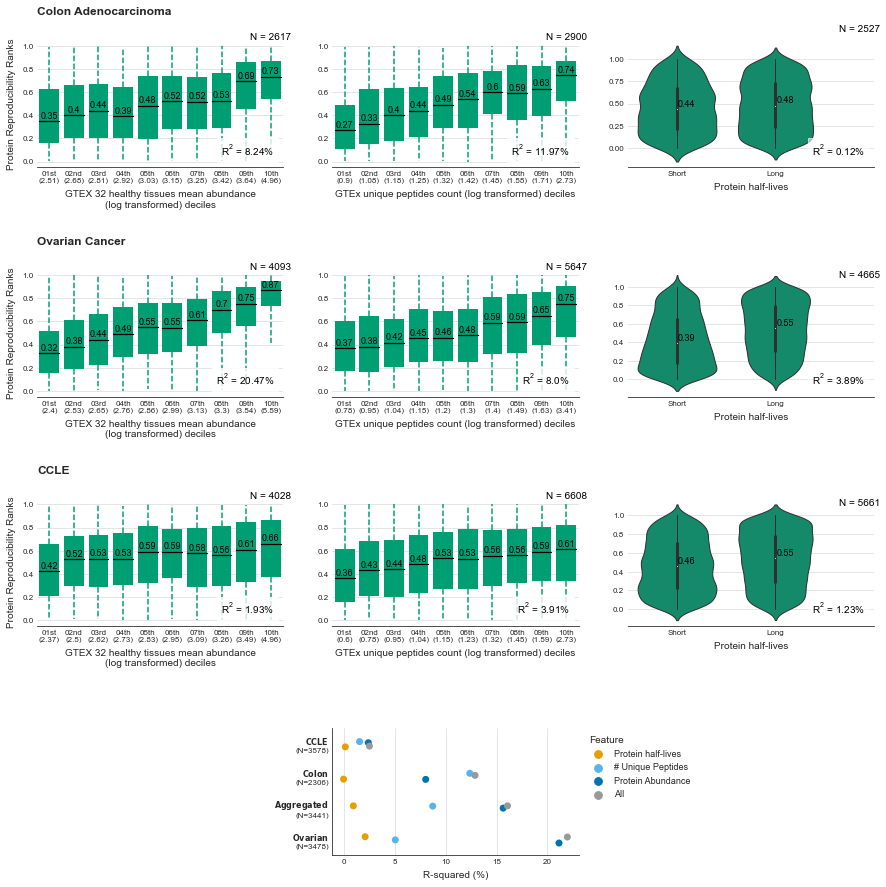

In [22]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values
with plt.rc_context({'axes.linewidth': 0.8}):
    figure, ax = plt.subplots(4, 3, figsize=(15,15))
    customized_plots.draw_boxplot(ax[0, 0], protein_abundance, replicates_colon_ranks, args[0])
    customized_plots.draw_boxplot(ax[1, 0], protein_abundance, replicates_ov_ranks, args[1])
    customized_plots.draw_boxplot(ax[2, 0], protein_abundance, replicates_ccle_ranks, args[2])
    customized_plots.draw_boxplot(ax[0, 1], protein_unique_peptides, replicates_colon_ranks, args[3])
    customized_plots.draw_boxplot(ax[1, 1], protein_unique_peptides, replicates_ov_ranks, args[4])    
    customized_plots.draw_boxplot(ax[2, 1], protein_unique_peptides, replicates_ccle_ranks, args[5])
    draw_violinplot(ax[0, 2], protein_half_lives_binary, replicates_colon_ranks, args[6])
    draw_violinplot(ax[1, 2], protein_half_lives_binary, replicates_ov_ranks, args[7])
    draw_violinplot(ax[2, 2], protein_half_lives_binary, replicates_ccle_ranks, args[8])
    ax[0,0].set_title("Colon Adenocarcinoma", weight='bold', y=1.15, size=12, loc='left')
    ax[1,0].set_title("Ovarian Cancer", weight='bold', y=1.15, size=12, loc='left')
    ax[2,0].set_title("CCLE", weight='bold', y=1.15, size=12, loc='left')
    customized_plots.draw_dotplot(ax=ax[3, 1], x='R-squared', y='Data', data=rsquared_factors, hue='Factor', 
                                  order=get_order(rsquared_factors), args=args[9], jitter=0.15)
    ax[3,1].spines['left'].set_visible(True)
    ax[3, 0].axis('off'); ax[3,2].axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=0.8)
    figure.savefig('../figures/S5.svg', bbox_inches='tight', dpi=300)

In [23]:
from scipy import stats
chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [24]:
def lrtest(llmin, llmax, df=3):
    lr = 2 * (llmax - llmin)
    p = chisqprob(lr, df) # llmax has 3 dof more than llmin as protein half-lives as has dummy variables - Long and Short
    return lr, p

In [25]:
for study in all_replicate_ranks: 
    print(study.name)
    llf_abundance = ols_fit(x=combined_factors['GTEx_Mean_Abundance'], y = study).llf
    llf_peptides = ols_fit(x=combined_factors['GTEx_Unique_Peptides'], y = study).llf
    llf_halflives = ols_fit(x=combined_factors[['Long', 'Short']], y=study).llf
    llf_combined = ols_fit(x=combined_factors, y=study).llf    
    
    lr, p = lrtest(llf_abundance, llf_combined)
    print('Abundance v/s combined model: LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))
    lr, p = lrtest(llf_peptides, llf_combined)
    print('Unique Peptides v/s combined model: LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))
    # Change degrees of freedom to 2 as protein-half-lives is represented as 2 features
    lr, p = lrtest(llf_halflives, llf_combined, df = 2) 
    print('Protein half-lives v/s combined model: LR test statistic = {:.2f},  p value = {:.5g}\n'.format(lr, p))

Colon
Abundance v/s combined model: LR test statistic = 126.67,  p value = 2.8283e-27
Unique Peptides v/s combined model: LR test statistic = 15.44,  p value = 0.0014785
Protein half-lives v/s combined model: LR test statistic = 320.44,  p value = 2.6194e-70

Ovarian
Abundance v/s combined model: LR test statistic = 38.27,  p value = 2.4769e-08
Unique Peptides v/s combined model: LR test statistic = 683.02,  p value = 1.0075e-147
Protein half-lives v/s combined model: LR test statistic = 789.87,  p value = 3.0353e-172

CCLE
Abundance v/s combined model: LR test statistic = 6.08,  p value = 0.10782
Unique Peptides v/s combined model: LR test statistic = 37.41,  p value = 3.7705e-08
Protein half-lives v/s combined model: LR test statistic = 87.89,  p value = 8.2236e-20

Aggregated
Abundance v/s combined model: LR test statistic = 19.65,  p value = 0.00020084
Unique Peptides v/s combined model: LR test statistic = 290.83,  p value = 9.5807e-63
Protein half-lives v/s combined model: LR tes

C:\Users\swath\Anaconda3\envs\omics_reproducibility\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
